# 把main.py拿過來作筆記

In [1]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import joblib

In [2]:
# merchandise = input("merchandise:")
merchandise = "USD/NTD"
data = pd.read_csv('history.csv', encoding= 'unicode_escape', header=[0])
data = data[['date',merchandise]]

In [56]:
x_train = []
y_train = []
#資料並沒有剛好每天都有
for i in range(0, 2688):
    temp = []
    for j in range(0, 31):
        if j == 30: #以差30列的價差當作異變數，如merchandise[1031]-merchandise[1001]、merchandise[1033]-merchandise[1003]
            y_train.append(data[merchandise][i+j] - data[merchandise][i])
        else: #其他0~29列的價差當自變數，如1003-1001、1030-1001、1003-1002
            temp.append(data[merchandise][i+j] - data[merchandise][i])
            # 每30天存成一個temp
            
    # x_train中，每31列是一個object，如第一項是[1030-1001, 1029-1001, ... , 1002-1001]，1001列後31列的價差都存成第一項，下一項就是以1002後的31列
    x_train.append(temp)

In [57]:
# 一樣概念，將後面的資料當作test
x_test = []
y_test = []
x_base = []
for i in range(2688, 3328):
    temp = []
    # x_base 存2688~(3359-31)的價格
    x_base.append(data[merchandise][i])
    for j in range(0, 31):
        if j == 30:
            y_test.append(data[merchandise][i+j] - data[merchandise][i])
        else:
            temp.append(data[merchandise][i+j] - data[merchandise][i])
    x_test.append(temp)

## cross_val_score

In [71]:
from sklearn.model_selection import cross_val_score

X = []
y = []

for i in range(0, 3328):
    temp = []
    for j in range(0, 31):
        if j == 30: 
            y.append(data[merchandise][i+j] - data[merchandise][i])
        else: 
            temp.append(data[merchandise][i+j] - data[merchandise][i])
            
    X.append(temp)

model = RandomForestRegressor(n_estimators=200)
# scores = cross_val_score(model, X, y, cv=5)
# print(scores)
# sum =0
# for i in scores:
#     sum  += i
# print("avg acc: ", sum/len(scores))


[0.97519788 0.97152752 0.97402812 0.97047881 0.97489895]
avg acc:  0.9732262550144111


In [75]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model, X, y, cv=5,return_estimator=True)
sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [76]:
cv_results['estimator']

[RandomForestRegressor(n_estimators=200),
 RandomForestRegressor(n_estimators=200),
 RandomForestRegressor(n_estimators=200),
 RandomForestRegressor(n_estimators=200),
 RandomForestRegressor(n_estimators=200)]

In [77]:
rfc_fit = cv_results['estimator']
# select the first model
rfc_fit = rfc_fit[0]

# save it
pickle. dump(rfc_fit, open('CrossValidateModel_1', 'wb')) # save as pickle

# load it
loaded_model = pickle. load(open('CrossValidateModel_1', 'rb'))

## DecisionTreeRegressor

In [67]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.95371574 0.92879404 0.95022893 0.94685148 0.94470658]


In [60]:
from sklearn import tree
import pydotplus
clf = tree.DecisionTreeRegressor().fit(x_train, y_train)
dot_data=tree.export_graphviz(clf
                              ,out_file=None
                              ,filled = True
                              ,rounded = True)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('USD_NTD.pdf')
y_predict = clf.predict(x_test)
for i in range(len(x_base)):
     y_predict[i] = y_predict[i] + x_base[i]
date_plot = data['date'][2718:3359] # 因此這邊要從+30天後的2444+30=2474的日期及價格開始
data_plot = data[merchandise][2718:3359]
date_plot.reset_index(inplace = True, drop = True)
data_plot.reset_index(inplace = True, drop = True)
error_sum = 0
for i in range(len(data_plot)):
    error_sum += abs(data_plot[i] - y_predict[i])/data_plot[i]
print('Average error: ' + "{:.4f}".format(error_sum/len(data_plot)*100) + '%')
print("accuracy: %.4f" % (100-error_sum/len(data_plot)*100),"%")

Average error: 0.2208%
accuracy: 99.7792 %


In [54]:
# A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset 
# uses averaging to improve the predictive accuracy and control over-fitting.
# n_estimators : The number of trees in the forest.
model = RandomForestRegressor(n_estimators=200).fit(x_train, y_train)
# dot_data=tree.export_graphviz(model[0]
#                               ,out_file=None
#                               ,filled = True
#                               ,rounded = True)
# graph=pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('Random_0.pdf')


In [55]:
# dot_data=tree.export_graphviz(model[1]
#                               ,out_file=None
#                               ,filled = True
#                               ,rounded = True)
# graph=pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('Random_1.pdf')
y_predict = model.predict(x_test)

In [45]:
# 原本的predict是價差
# 把它變回價格(1031-1001+1001=1031的價格)
for i in range(len(x_base)):
     y_predict[i] = y_predict[i] + x_base[i]

In [46]:
date_plot = data['date'][2698:3359] # 因此這邊要從+30天後的2444+30=2474的日期及價格開始
data_plot = data[merchandise][2698:3359]
# When we reset the index, the old index is added as a column, and a new sequential index is used
# use the drop parameter to avoid the old index being added as a column
# inplace:布爾值，如果為True，則對原始 DataFrame 本身進行更改
date_plot.reset_index(inplace = True, drop = True)
data_plot.reset_index(inplace = True, drop = True)
# plt.plot(date_plot, y_predict) 
# plt.plot(date_plot, data_plot)
# plt.show()

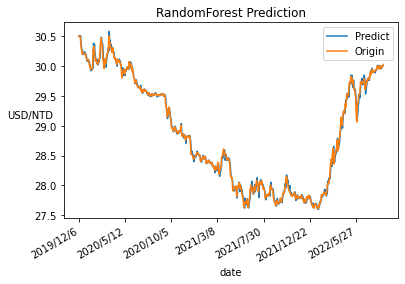

In [47]:
plt.plot(date_plot, y_predict)
plt.plot(date_plot, data_plot)
# line_blue = Predict, line_orange = Origin
plt.legend(['Predict','Origin'])
ax = plt.gca() # 使用 plt.gca() 取得軸物件
plt.xlabel('date')
# ax.set_xlabel('date')
plt.ylabel(merchandise, rotation = 0)
# ax.set_ylabel(merchandise, rotation = 0)
plt.title("RandomForest Prediction")

# ax = plt.subplot(1,1,1) #row,column,plot(第幾個點)，把整張圖當作1*1的矩陣的話，全部就只有一個點
    
ax.xaxis.set_major_locator(ticker.MultipleLocator(100)) #調整間距
# ax.xaxis.set_major_locator(dates.DayLocator(interval=100)) #也是調整間距，限定日期
plt.gcf().autofmt_xdate() # 將日期以 45 度斜放
plt.show()

In [48]:
error_sum = 0
for i in range(len(data_plot)):
    error_sum += abs(data_plot[i] - y_predict[i])/data_plot[i]
print('Average error: ' + "{:.4f}".format(error_sum/len(data_plot)*100) + '%')
print("accuracy: %.4f" % (100-error_sum/len(data_plot)*100),"%")

Average error: 0.1481%
accuracy: 99.8519 %


In [36]:
# save model
# joblib.dump(model, "./ExchangeRate.joblib") #save as joblib
pickle. dump(model, open('ExchangeRate_EU_USD', 'wb')) # save as pickle

In [33]:
# load the model from disk.
loaded_model = pickle. load(open('ExchangeRate', 'rb'))